<h1> <center> Predicting the NHL Playoffs Using a Bagged Elastic Net Regression </center></h1> <br>

This is straight up a bootstrap aggregated elastic net GLM that has objective function:

$$log(L(p)) - \lambda\left[\frac{{1-\alpha}}{2} \sum_{j = 1}^p B_{j}^2 + \alpha \sum_{j = 1}^p \lvert B_{j}\rvert \right]$$ <br>

where $log(L(p))$ is the loglikelihood function of the binomial distribution (in this case of a binary classification) and  $B_{j}$  are the fitted coefficients for each feature. We tune over values of $\lambda$ and $\alpha$ to get the best out of sample AUROC. Note that $log[L(p)] = \sum_{i=1}^n [y_{i} * log(p_{i}) + (1-y_{i}) * log(1-p_{i})]$ but $p_{i} = \frac{exp(-X_{i}B)}{1 + exp(-X_{i}B)}$ which is clearly not trivial to maximize with respect to B.

I chose this model mostly because I wanted a framework that had embedded feature selection while still representing predictions as a linear combination of features. The sample size is low, so a "simple" linear function is probably the best we can get right now. From the loss function, the model explicitly controls for both collinearity in predictors (large amounts in this problem) through the ridge $\sum_{j = 1}^p B_{j}^2$ and noisy predictors through the LASSO  $\sum_{j = 1}^p \lvert B_{j}\rvert$ . $\alpha$ controls the mixing amount of the two penalties and $\lambda$ controls the entire contribution of penalty from both the ridge and LASSO. It should be clear that the model penalizes large coefficients, a symptom of bad collinearity or perfect separation in any linear regression while also allowing for the coefficient of a predictor to be exactly zero if the predictor is not useful in maximizing out of sample performance measures. A model that maximizes the log likelihood is not necessarily the best model if it is overfit; in some ways this is similar to the overall idea of Akaike's Information Criterion for finding a parsimonious model but the penalty term is very different. One easy way to interpret this model is as follows: if the loglikelihood function does not increase enough (or at all) to warrent a relatively "large"  $B_{j}$, then the influence the variable has on the predictions from the model is lowered by shrinking the variable's corresponding coefficient (in magnitude). In some cases, if the variable is completely non-predictive than the coefficient for that variable is shrunk to zero, meaning that the variable is straight up not included in the model anymore. Furthermore, coefficients that are arbitrarily (and not meaningfully) large due to collinearity/perfect separation are shrunk to smaller values to decrease their arbitrary large influence on predictions, reducing the variance of out of sample predictions (and therefore improving out of sample predictive performance).

The model is the best out of all models tried giving an AUROC of about 0.72 using about 140 features as input (though many aren't actually used in final predictions). It predicts slightly better than the bagged gradient boosted GLM that I tried. This means that in general, if we were to randomly pick a true winner and a true loser from the dataset 100 times, the bagged elastic net model would be expected to rank the true winner as having a higher probability of being a winner over the true loser about 72 times. Not bad for how hard NHL games are to predict.

The script takes kind of a while to run since we are doing 150 repeats. Be warned that this script is multithreaded; so your CPU will be pinned if you run it.

<h3><center>Reported Validation Scores (150 Repeats of Nested Cross Validation): </center></h3>

Final AUROC: 0.719446589446589 with a 95% confidence interval given by [0.714916945998058, 0.723976232895121]



In [1]:
#Set the directory for parallel computation status checks. Change this to any folder on your computer so that we can monitor 
#the status of the repeated cross validation.
setwd("C:/Users/Brayden/Documents/NHLModel/Status")

In [2]:
#Dependencies

library(glmnet)
library(caret)
library(pROC)
library(tidyverse)
library(recipes)
library(moments)
library(doParallel)
library(foreach)
library(fastknn)
library(boot)

Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.5.2"Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'caret' was built under R version 3.5.2"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.5.2"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.1"Warning message:
"package 'pROC' was built under R version 3.5.2"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following object is masked from 'package:glmnet':

    auc

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'tidyverse' was built under R version 3.5.2"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.0.1     v purrr   0.2.5
v tidyr   0.8.2     v dplyr   0.7.8
v readr   1.3.1     v stringr 1.3.1
v tibble  2.0.1     v forcats 0.3.0
Warn

This is the main modelling function. We bag 15 elastic net models.

In [3]:
#..................................Bagging Function...................................#
baggedModel = function(train, test, label_train, alpha.a, s_lambda.a){
  
  set.seed(40689)
  samples = caret::createResample(y = label_train, times = 15)
  pred = vector("list", length(samples))
  varImp = vector("list", length(samples))
  
  for (g in 1:length(samples)){
    train_temp = train[samples[[g]], ]
    a = label_train[samples[[g]]]
    modelX = glmnet(x = data.matrix(train_temp[, !names(train_temp) %in% c("ResultProper")]), y = a, family = "binomial", alpha = alpha.a, nlambda = 120, standardize = FALSE)
    s_lambda.a = case_when(s_lambda.a > length(modelX$lambda) ~ length(modelX$lambda), TRUE ~ s_lambda.a)
    pred[[g]] = predict(modelX, newx = data.matrix(test[, !names(test) %in% c("ResultProper")]), type = "response")[, s_lambda.a]
    varImp[[g]] = tibble::rownames_to_column(varImp(modelX, lambda = modelX$lambda[s_lambda.a]), var = "Variable")
    colnames(varImp[[g]])[2] = paste("Overall:", g, sep = "")
    remove(modelX, train_temp, a)
  }
  
  pred = bind_cols(pred) %>%
    transmute(Predicted = rowMeans(.))
  
  varImp = varImp %>% Reduce(function(x,y) left_join(x,y, by = "Variable"), .) 
  
  means = varImp %>% select_if(is.numeric) %>% transmute(VariableImportance = rowMeans(.))
  
  varImp = tibble(Variable = varImp$Variable, meanImportance = means$VariableImportance)
  
  list(Predictions = pred$Predicted, VariableImportance = varImp)
}

The log loss function which is not used currently. This can be easily added in if needed.

In [4]:
#..................................Log Loss Function....................................#

logLoss = function(scores, label){
  
  if (is.factor(label)){
    u = ifelse(label ==  "W", 1,0)
  } else{
    u = label
  }
  
  tmp = data.frame(scores = scores, target = u)
  tmp = tmp %>% mutate(scores = ifelse(scores == 1, 0.9999999999999999, ifelse(scores == 0 , 0.0000000000000001, scores))) %>%
    mutate(logLoss = -(target * log(scores) + (1-target) * log(1-scores)))
  
  mean(tmp$logLoss)
}


The PCA function used to create PCA variables. I did this as a function because I wanted to keep the original variables fed into the transformation, as well as the principle components.

In [5]:
#..................................PCA Function....................................#
#I tried to center and scale these variables after they were mistakenly left uncentered and unscaled (recall: the model has a loss function that is a function of the 
#magnitude of the parameters themselves, hence, it is vital we center and scale variables to be unitless so that the magnitude of such variables are not unfairly penalized.
#However....the validation results were quite different than before, roughly a drop of 0.03-0.04 in AUROC which is quite significant.)

addPCA_variables = function(traindata, testdata, standardize = FALSE){
  
  traindata_tmp = traindata[, !names(traindata) %in% c("ResultProper")] %>% select_if(., is.numeric)
  testdata_tmp = testdata[, !names(testdata) %in% c("ResultProper")] %>% select_if(., is.numeric)
  
  pca_parameters = prcomp(traindata_tmp, center = FALSE, scale. = FALSE)
  pca_traindata = predict(pca_parameters, newdata = traindata_tmp)[,1:5] %>% as_tibble(.) 
  
  if(standardize == TRUE){
    
    pca_train.params = caret::preProcess(pca_traindata, method = c("center", "scale"))
    pca_traindata = predict(pca_train.params, newdata = pca_traindata)
    pca_newdata = predict(pca_parameters, newdata = testdata_tmp)[,1:5] %>% as_tibble(.) %>% predict(pca_train.params, newdata = .)
    
  }else{
    
    pca_newdata = predict(pca_parameters, newdata = testdata_tmp)[,1:5] %>% as_tibble(.) 
    
  }
  
  
  list(train = bind_cols(traindata, pca_traindata), test = bind_cols(testdata, pca_newdata))
}

The kNN function; is used now in distances mode.

In [6]:
#..................................kNN Function....................................#
#Distances = cumulative distance from observation to the first, second, third, etc. nearest neighbour for each class label. 
#So for example, knn1 = distance from observation to first nearest neighbour that has label "W". knn2 = distance from observation
#to second nearest neighbour that has label "W". knn3 = distance from observation to first nearest neighbour that has label "L", 
#and knn3 = distance from observation to second nearest neighbour that has label "L".

#Probabilities = calculates the proportion of winners out of the k most closest neighbours to an observation

addKNN_variables = function(traindata, testdata, include_PCA = FALSE, distances = TRUE){
  
  #Selects variables that are top performing....
  traindata_tmp = traindata[, !names(traindata) %in% c("ResultProper")] %>% select(., H2H, WeightedGPS, Q2Record, PowerPlayOppurtunities, PenaltyKillPercentage, VegasOpeningOdds, "TOI% QoT_mean")
  testdata_tmp = testdata[, !names(testdata) %in% c("ResultProper")] %>% select(., H2H, WeightedGPS, Q2Record, PowerPlayOppurtunities, PenaltyKillPercentage, VegasOpeningOdds, "TOI% QoT_mean")
  
  if(include_PCA == TRUE){
    
    traindata_tmp = traindata %>% select_if(., is.numeric)
    testdata_tmp = testdata %>% select_if(., is.numeric)
    
  }else{
    
    traindata_tmp = traindata %>% select_if(., is.numeric) %>% as_tibble(.) %>% select(-starts_with("PC"))
    testdata_tmp = testdata %>% select_if(., is.numeric) %>% as_tibble(.) %>% select(-starts_with("PC"))
    
  }
  
  if (distances == TRUE){
    
    newframeswithKNN = fastknn::knnExtract(xtr = data.matrix(traindata_tmp), ytr = traindata$ResultProper, xte = data.matrix(testdata_tmp), k = 1, normalize = NULL)
    KNN_train = newframeswithKNN$new.tr %>% as_tibble(.) 
    
    KNN_train.params = caret::preProcess(KNN_train, method = c("center", "scale"))
    KNN_train = predict(KNN_train.params, newdata = KNN_train)
    
    KNN_test = newframeswithKNN$new.te %>% as_tibble(.) %>% predict(KNN_train.params, newdata = .)
    
    list(train = bind_cols(traindata, KNN_train), test = bind_cols(testdata, KNN_test))
    
  }else{
    
    KNN_train  = tibble(knn_W = fastknn(xtr = data.matrix(traindata_tmp), ytr = traindata$ResultProper, xte = data.matrix(traindata_tmp), k = 5, method = "vote", normalize = NULL)$prob[,2]) 
    
    KNN_train.params = caret::preProcess(KNN_train, method = c("center", "scale"))
    KNN_train = predict(KNN_train.params, newdata = KNN_train)
    
    KNN_test = tibble(knn_W = fastknn(xtr = data.matrix(traindata_tmp), ytr = traindata$ResultProper, xte = data.matrix(testdata_tmp), k = 5, method = "vote", normalize = NULL)$prob[,2]) %>%
      predict(KNN_train.params, newdata = .)
    
    list(train = bind_cols(traindata, KNN_train), test = bind_cols(testdata, KNN_test))
    
  }
  
}

The data represents differences in a stat from the first seeds perspective. This way we get a single prediction per a series. There could be better ways to do this, perhaps a ratio, product, sum, etc. I thought a difference would make the most sense.

Make sure to change the directories to pull in data from wherever the "Required Data Sets" folder is located. The "Required Data Sets" folder is in the GitHub repository.

In [7]:
#..................................Read data in....................................#
#Change directories to pull in data from the "Required Data Sets" folder located in the repository.

cat("Reading in Data..... \n")
allData = read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/HockeyReference2.csv") %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/HockeyReference1.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/CorsicaAllTeamStats.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/CorsicaGameScoreStats.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/ELORatings.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/ESPNStats.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/FenwickScores.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/NHLOfficialStats.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/SCFScores.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/VegasOddsOpening.csv")) %>%
  bind_cols(read_csv("C:/Users/Brayden/Documents/GitHub/NHLPlayoffs/Required Data Sets/EvolvingHockey_WAR.csv")) %>%
  mutate(ResultProper = as.factor(ResultProper)) %>%
  filter(!is.na(ResultProper))

Reading in Data..... 


Parsed with column specification:
cols(
  ResultProper = col_character(),
  PlayerPoints = col_double(),
  WeightedGoalieSavePercntage = col_double(),
  WeightedGPS = col_double(),
  H2H = col_double(),
  Q1Record = col_double(),
  Q2Record = col_double(),
  Q3Record = col_double(),
  Q4Record = col_double(),
  SDRecord = col_double()
)
Parsed with column specification:
cols(
  AverageAge = col_double(),
  GoalDiff = col_double(),
  GoalsAgainst = col_double(),
  GoalsFor = col_double(),
  OTL = col_double(),
  PenaltyKillPercentage = col_double(),
  PenaltyMinsPG = col_double(),
  Points = col_double(),
  PointsPercentageofMax = col_double(),
  PowerPlayGoals = col_double(),
  PowerPlayOppurtunities = col_double(),
  PowerPlayPercentage = col_double(),
  RegularSeasonWinPercentage = col_double(),
  ShotPercentage = col_double(),
  SOG = col_double(),
  SOS = col_double(),
  SRS = col_double()
)
Parsed with column specification:
cols(
  CF._Team = col_double(),
  CF_Per60Team = col_dou

In [8]:
#...................................Engineering of some features..................#

allData = allData %>% 
  mutate(Round = as.factor(rep(c(1,1,1,1,1,1,1,1,2,2,2,2,3,3,4),13))) %>%
  mutate(PenaltyMinstoPowerPlaylog = sign(PenaltyMinsPG*60*82 /PowerPlayPercentage) * log(abs(PenaltyMinsPG*60*82 /PowerPlayPercentage) + 1)) %>%
  mutate(Ratio_of_SRStoPoints = (SRS/Points)^1/3) %>%
  mutate(AverageGoalDiff_PerGame = GoalsFor/82) %>%
  mutate(AveragePenaltyDiff_PerGame = PenaltyMinsPG/82) %>%
  mutate(PowerPlaytoPenaltyKill = sign(PowerPlayPercentage/PenaltyKillPercentage) * log(abs(PowerPlayPercentage/PenaltyKillPercentage) + 1)) %>%
  mutate(PPO_x_PenaltyKill = PowerPlayOppurtunities * PenaltyKillPercentage) %>%
  mutate(PointsPercentage = Points/164) %>%
  mutate(GS_max_log = sign(GS_mean) * log(abs(GS_mean) + 1)) %>%
  mutate(CA_Per60Team_log = sign(CA_Per60Team) * log(abs(CA_Per60Team) + 1)) %>%
  mutate(Ratio_of_GoalstoGoalsAgainstlog = sign(GoalsFor/GoalsAgainst) * log(abs(GoalsFor/GoalsAgainst) +1)) %>%
  mutate(Ratio_of_HitstoBlockslog = sign(HitsatES/BlocksatES) * log(abs(HitsatES/BlocksatES) + 1)) %>%
  mutate(SCFtoGoalsAgainstlog = sign(SCF/GoalsAgainst) * log(abs(SCF/GoalsAgainst) + 1)) %>%
  mutate(CorsiDifftoSOSlog = sign((CF_Per60Team - CA_Per60Team)/SOS) * log(abs((CF_Per60Team - CA_Per60Team)/SOS) + 1)) %>%
  mutate(xGDifftoSOS = (xGF.60 - xGA.60)/SOS) %>% 
  mutate(GStoSOS = GS_mean / SOS) %>%
  mutate(SRStoSOS = SRS/SOS) %>%
  mutate("ixGF/60_max.TO.Rel CF%_max" = allData$'Rel CF%_max' / allData$'ixGF/60_max') %>%
  mutate_if(is.numeric, funs(ifelse(is.nan(.), 0,.))) %>%
  mutate_if(is.numeric, funs(ifelse(is.infinite(.), 0,.)))

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200, scipen = 999)

In [9]:
#...................................Check skewness and kurtosis..................#

kurt = allData %>% select_if(., is.numeric) %>% summarize_all(., funs(moments::kurtosis(., na.rm=TRUE))) %>%
                                         gather(., Variable, Kurtosis)
allData %>% select_if(., is.numeric) %>% summarize_all(., funs(moments::skewness(., na.rm=TRUE))) %>%
                                         gather(., Variable, Skewness) %>%
                                         left_join(., kurt, by = "Variable")
rm(kurt)
allData %>% select_if(., is.numeric) %>% summarize_all(., funs(moments::skewness(., na.rm=TRUE))) %>%
                                          gather(., Variable, Skew) %>%
                                          filter(., abs(Skew) >= 1)

Variable,Skewness,Kurtosis
PlayerPoints,0.099260397,2.923301
WeightedGoalieSavePercntage,0.078557224,3.243056
WeightedGPS,0.428811589,3.260166
H2H,0.026571103,2.527590
Q1Record,0.125765210,3.121404
Q2Record,0.318525130,2.894463
Q3Record,0.027757159,2.942516
Q4Record,0.029090232,2.952298
SDRecord,0.088293186,2.651121
AverageAge,0.556504000,3.689177


Variable,Skew
GS/60_max,1.019528
P1/60_max,1.834728
P1/60_sd,2.074626
P1_max,1.835278
P1_sd,2.076483
Ratio_of_SRStoPoints,-1.701059
PPO_x_PenaltyKill,-2.498578
ixGF/60_max.TO.Rel CF%_max,-1.862722


The preprocessing recipe; mostly straightforward stuff. I remove all zero variance predictors since these variables are inherently useless and present numerical problems (though I don't think we have such variables). Standard center and scaling which is essential for the elastic net (since fitted coefficients are in the units of the response/variable, if the magnitude of the variable is naturally small these coefficients will be "large" and hence be arbitrarily penalized), as well as creating dummy variables for any categorical variables.

Some interaction variables are specified and we use knn imputation with k = 15 nearest neighbours for imputing the missing data from the 2006-2007 seasons as well as the 2018 season.

In [10]:
#.......................Define recipe.............................................#

preProcess.recipe = function(trainX){
  
  mainRecipe = recipe(ResultProper ~., data=trainX) %>%
    step_dummy(all_predictors(), -all_numeric()) %>%
    step_zv(all_predictors()) %>%
    step_interact(terms = ~ SRS:Fenwick:ELORating) %>%
    step_interact(terms = ~ H2H:VegasOpeningOdds) %>%
    step_interact(terms = ~ RegularSeasonWinPercentage:contains("Points")) %>%
    step_interact(terms = ~ FaceoffWinPercentage:ShotPercentage) %>%
    step_interact(terms = ~ contains("Round"):VegasOpeningOdds) %>%
    step_interact(terms = ~ SDRecord:SOS) %>%
    step_zv(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors()) %>%
    step_knnimpute(neighbors = 15, all_numeric(), all_predictors()) 
  
  mainRecipe
}

The random search function for hyper parameter tuning; not really a grid search anymore so that's misleading. Randomly chooses an alpha and a lambda to try and replaces the current best values if the resulting model is better.

In [11]:
#........................Define random search function..................................#

randomGridSearch = function(iterations, innerTrainX, innerTestX, seed.a){
  
  score = 0
  alpha.fin = numeric(1)
  lambda.fin = integer(1)
  
  set.seed(seed.a)
  alpha_val = as.numeric(runif(n = iterations, min = 0, max = 1))
  s.lambda_val = as.integer(sample(1:90, iterations, replace = TRUE))
  
  for(m in 1:iterations){
    
    writeLines(paste("Iteration:", m, sep = " "))
    
    modelX = baggedModel(train = innerTrainX[, !names(innerTrainX) %in% c("ResultProper")], test = innerTestX, 
                         label_train = innerTrainX$ResultProper, alpha.a = alpha_val[m], s_lambda.a = s.lambda_val[m])
    
    score.new = roc(response = innerTestX$ResultProper, predictor = modelX$Predictions, levels = c("L", "W"))$auc
    
    if(score.new > score){
      alpha.fin = alpha_val[m]
      lambda.fin = s.lambda_val[m]
      score = score.new
    }
  }
  list(alpha = alpha.fin, lambda = lambda.fin)
}

The model pipe for the outer validation. We split the entire dataset into three folds and save one for the test set; the other two folds form the training set and are sent to the inner pipe. We repeat this so that every fold serves as the test set once.

In [12]:
#.........................Define outer pipe for the outer cross validation fold...........................................#

modelPipe.outer = function(j, folds, lambda.final, alpha.final){
  
  train.param = prep(preProcess.recipe(trainX = allData[-folds[[j]],]), training = allData[-folds[[j]],])
  train = bake(train.param, new_data = allData[-folds[[j]], ])
  test = bake(train.param, new_data = allData[folds[[j]], ])
  
  frameswithPCA = addPCA_variables(traindata = train, testdata = test)
  
  train = frameswithPCA$train
  test = frameswithPCA$test
  
  rm(train.param, frameswithPCA)
  
  frameswithKNN = addKNN_variables(traindata = train, testdata = test, distances = TRUE)
  
  train = frameswithKNN$train
  test = frameswithKNN$test
  
  rm(frameswithKNN)
  
  model = baggedModel(train = train[, !names(train) %in% c("ResultProper")], test=test, label_train = train$ResultProper, 
                      alpha.a = alpha.final, s_lambda.a = lambda.final)
  
  ROC = roc(response = test$ResultProper, predictor = model$Predictions, levels = c("L", "W"))$auc
  VarImp = model$VariableImportance
  
  list(ROC = ROC, VarImp = VarImp)
}

The subsequent two folds from the outer validation now form the training set. This set is then partioned again with an 80/20 split and we use this partioning only to tune hyper parameters. This is what is referred to as nested cross validation to avoid overly optimistic results.

In [13]:
#.........................Define inner pipe for the inner cross validation...........................................#
modelPipe.inner = function(k, folds, seed.a){
  
  mainTrain = allData[-folds[[k]], ]
  
  set.seed(seed.a)  
  innerFolds = createDataPartition(y = mainTrain$ResultProper, times = 1, p = 0.75)
  
  train.param = prep(preProcess.recipe(trainX = mainTrain[innerFolds[[1]],]), training = mainTrain[innerFolds[[1]],])
  train = bake(train.param, new_data = mainTrain[innerFolds[[1]],])
  test = bake(train.param, new_data = mainTrain[-innerFolds[[1]],])
  
  frameswithPCA = addPCA_variables(traindata = train, testdata = test)
  
  train = frameswithPCA$train
  test = frameswithPCA$test
  
  rm(train.param, frameswithPCA)
  
  frameswithKNN = addKNN_variables(traindata = train, testdata = test, distances = TRUE)
  
  train = frameswithKNN$train
  test = frameswithKNN$test
  
  rm(frameswithKNN)
  
  results = randomGridSearch(iterations = 140, innerTrainX = train, innerTestX = test, seed = seed.a)
  
  
  list(alpha = results$alpha, lambda = results$lambda)
  
}

Process variable importance; these metrics should be taken with a grain of salt since the majority of these variables are collinear and if we want to actually gauge the effect of such variables on the probability of winning a NHL series we should use statistical inference and be (much) more careful in specifying our model.

In [14]:
#..........................Processed variable importance output from the base model................................#
processVarImp = function(varImpRaw){
  
  varImpNames = varImpRaw %>% 
    select(., contains("Variable")) %>%
    .[,1]
  
  final = varImpRaw %>% 
                        select(., contains("Importance")) %>%
                        transmute(Importance = rowMeans(.)) %>%
                        bind_cols(varImpNames, .)

  final
}

The main script that calls the functions above. Does each repeat in parallel.

In [15]:
#..........................Global Envrionment..............................................................#
set.seed(40689)
seeds = sample(1:1000000000, 150, replace = FALSE)
ROC.status = rep(as.numeric(NA), length(seeds))

cluster = makeCluster(detectCores(), outfile = "messages.txt")
registerDoParallel(cluster)

results = foreach(p = 1:length(seeds), .combine = "c", .packages = c("tidyverse", "glmnet", "caret", "pROC", "recipes", "fastknn")) %dopar% {
  
  set.seed(seeds[p])
  allFolds = caret::createFolds(y = allData$ResultProper, k = 3)
  
  bestParam = bind_rows(lapply(1:length(allFolds), FUN = modelPipe.inner, folds = allFolds, seed.a = seeds[p])) 
  finalResults = mapply(FUN = modelPipe.outer, j = 1:length(allFolds), lambda.final = bestParam$lambda, alpha.final = bestParam$alpha, 
                        MoreArgs = list(folds = allFolds), SIMPLIFY = FALSE)
  
  ROC = mean(unlist(lapply(finalResults, function(x){unlist(x$ROC)})))
  ROC.status[p] = ROC
  
  VarImp = processVarImp(varImpRaw = as_tibble(bind_cols(lapply(finalResults, function(x){(x$VarImp)}))))
  
  writeLines(paste("REPEAT:", p, "...", "Running Average AUROC:", mean(ROC.status, na.rm = TRUE), sep = " "))
  list(ROC = ROC, VarImp = VarImp)
  
}

stopCluster(cluster)
rm(cluster)

Displays the results and gives a 95% confidence interval. 

In [16]:
finalROC = unlist(results[c(seq(1, length(results), 2))])
finalVarImp = processVarImp(varImpRaw = results[c(seq(2, length(results),2))] %>% Reduce(function(x,y) left_join(x,y, by = "Variable"),.)) 

In [17]:
#...................................Bootstrap the vector finalROC and RFE.data..............................#

mean.custom = function(x, d){
  
  mean(x[d])
  
}

bootstrapped.All.CI = boot.ci(boot(data = finalROC, statistic = mean.custom, R = 10000), type = "basic")

In [18]:
#...................................Paste the Results.........................................................#

paste("Final AUROC: ", round(mean(finalROC),5), " with a 95% confidence interval given by via. Bootstrapping: ", "[", round(bootstrapped.All.CI$basic[1,4],5), ", ", 
      round(bootstrapped.All.CI$basic[1,5],5), "]", sep = "")

finalVarImp %>% arrange(., -Importance)

[1] "Final AUROC: 0.65497 with a 95% confidence interval given by via. Bootstrapping: [0.65189, 0.65827]"

Variable,Importance
TOI% QoT_mean,0.09519160037
PC1,0.06968944742
H2H,0.03864969131
VegasOpeningOdds,0.03328347555
WeightedGPS,0.03297717935
Q2Record,0.03109388725
PowerPlayOppurtunities,0.02925075268
CorsiDifftoSOSlog,0.02844826793
FaceoffWinPercentage,0.02818679407
SOG_Last20,0.02781296684


In [19]:
write_csv(finalVarImp %>% arrange(., -Importance), "VarImportanceApril4th2019.csv")

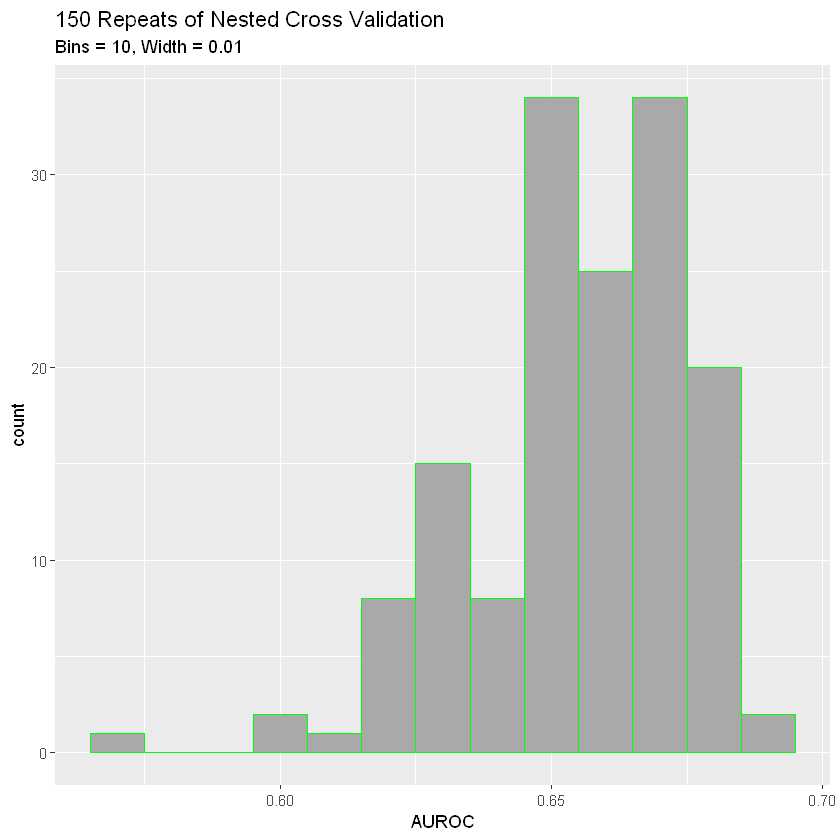

In [20]:
#..............................................Graphing the AUROC scores.........................#

graphingParameters = tibble(ROC = finalROC)

ggplot(data = graphingParameters, aes(graphingParameters$ROC), colour = "Hist") +
  geom_histogram(bins = 10, binwidth = 0.01, colour = "green", fill = "darkgrey") +
  labs(title = "150 Repeats of Nested Cross Validation", x = "AUROC", subtitle = "Bins = 10, Width = 0.01")